In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('hotel_bookings.csv')

# Introduction
So this data set is from kaggle website, I chose this data because it is relevant to what I am studying in University.
<br> The data are booking records due to arrive between the 1st of July of 2015 and the 31st of August 2017.
<br> What I will do with this data are:
 Cleaning, EDA, Building a logistic regression model to predict cancellation bookings.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# Clean and prepare the data
Let's deal with the missing value first.

In [4]:
df.isna().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
hotel                                  0
previous_cancellations                 0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
adults                                 0
stays_in_week_ni

## Replace NA
There are a lot of missing values in the company column, meaning that the guests are FIT (Free individual traveler)
<br>Missing values in agent column, meaning that the guests probably booked the room through the hotel directly.
<br>Children columns has missing values only 4 rows, so I will assume that it was a mistake of data entry, I will just replace them by 0.

In [5]:
# company column
# Containing company ID
# Replace NA by 0, no company
df["company"].fillna(0, inplace=True)
# agent column
# Containing agent ID
# Replace NA by 0, no agent
df['agent'].fillna(0, inplace=True)
# children column
df['children'].fillna(0, inplace=True)
df.isna().any()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                            True
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                             False
company                           False


Now the only problem column is a country column, since it contributes such a small proportion, so I will just drop them.

In [6]:
df.dropna(inplace=True)
df.isna().any()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                             False
company                           False


## Weird records
I will filter a data a bit more by filtering out the row that has adults + children + babies = 0, which means there was no guests in that booking, so it should be screened out.

In [7]:
filter_sumzero = df.loc[:,['adults','children','babies']].sum(axis=1) == 0
print(f"There are total rows of : {sum(filter_sumzero)} rows")

# Filter out
df = df[~filter_sumzero]

There are total rows of : 170 rows


Also some rows that have undefined market_segment

In [8]:
filter_undefined = df['market_segment'] == 'Undefined'
print(f"There are total rows of undefined rows : {sum(filter_undefined)} rows")
df = df[~filter_undefined]

There are total rows of undefined rows : 2 rows


## Our scope will be only top 10 countries that have the highest amount number of bookings
It will be easier for us to see the significant insight, many countries have only 1 row in the data.

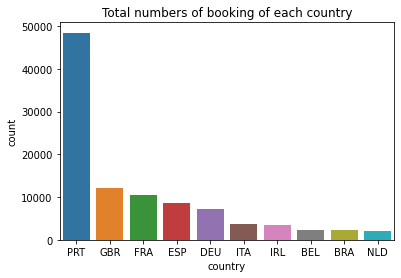

The amount of rows of the top 10 countries data: 100649 rows


In [9]:
# Plot top 10 countries
top10country = df.country.value_counts().head(10).reset_index()
top10country.columns = ['country','count']
sns.barplot(data=top10country, x='country',y='count')
plt.title('Total numbers of booking of each country')
plt.show()

# Filter data only top 10 countries
df = df[df['country'].isin(top10country['country'])]
print('The amount of rows of the top 10 countries data: {} rows'.format(len(df)))

# EDA
We are going to answer business questions with data.
<br>The questions are:
1. What were the most popular distribution channel
2. Which group of customers contributed highest proportion of revenue.
3. When were the busy months
4. How many days guest usually stay
5. What were the factors that influence cancellation of booking

## What are the most popular distribution channel

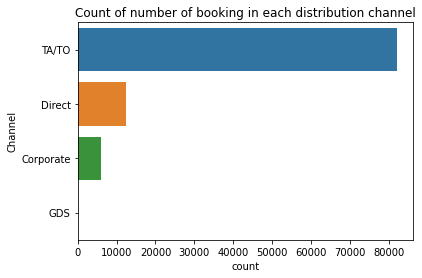

In [10]:
count_channel = df.groupby('distribution_channel')['hotel'].count().sort_values(ascending=False).reset_index()\
    .rename(columns={'distribution_channel':'Channel','hotel':'count'})

# Drop undefined channel
count_channel.drop(4, inplace=True)

# Plot
sns.barplot(data=count_channel, y='Channel',x='count',orient='h')
plt.title("Count of number of booking in each distribution channel")
plt.show()

Travel agency and tour operator is the most popular so far, travel agency is also including online platform booking like booking.com agoda for example.
And next is directly booking through hotel (through website, call, email)

## Which group of customers contributed highest proportion of revenue.
ADR is a common KPI of hotel to measure profitability or revenue
<br>ADR = Revenue of that day/Total rooms

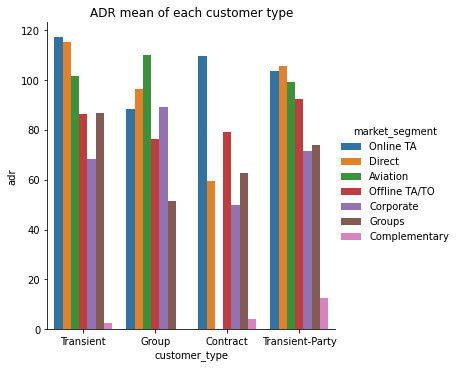

In [11]:
adr_mean_customer_market = df.groupby(['customer_type','market_segment']).agg({'hotel':'count', 'adr':'mean'}).reset_index()\
.sort_values('adr',ascending=False)\

sns.catplot(data=adr_mean_customer_market, x='customer_type', y='adr', hue='market_segment',kind='bar')
plt.title('ADR mean of each customer type')
plt.show()

<Figure size 1080x864 with 0 Axes>

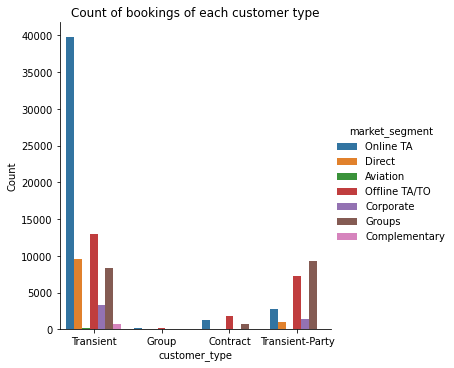

In [12]:
plt.figure(figsize=(15,12))
sns.catplot(data=adr_mean_customer_market, x='customer_type', y='hotel', hue='market_segment',kind='bar')
plt.title('Count of bookings of each customer type')
plt.ylabel('Count')
plt.show()

the FIT or Transient generated more revenue than other group in both Online TA and direct distribution channel.
<br> With 2 questions, hotels should spend their resources to Online TA the most, since it both created a high ADR and number of bookings  (Popular in Transient). 
<br>Also, in high season the hotel should get FIT as much as possible to maximize revenue.
<br> Aviation also generated a high ADR, but their booking amount was small.

## When were the busy months

C:\Users\fnvin\AppData\Local\Temp\ipykernel_21884\4113158932.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ordered_months,rotation=45)


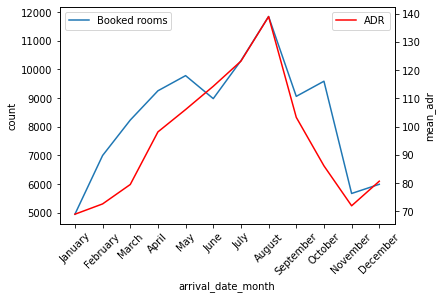

In [13]:
# Change the dtype to categorical to order
ordered_months = ["January","February","March","April","May","June","July",
                  "August","September","October","November","December"]
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'],
                                       categories=ordered_months,
                                       ordered=True)



mean_adr_by_month = df.groupby('arrival_date_month').agg({'adr':'mean','hotel':'count'}).rename(columns={'adr':'mean_adr','hotel':'count'})
fig,ax1 = plt.subplots(sharex=True)
sns.lineplot(x='arrival_date_month', y='count',data=mean_adr_by_month, ax=ax1, label='Booked rooms')
ax2 = ax1.twinx()
sns.lineplot(x='arrival_date_month', y='mean_adr', data=mean_adr_by_month, ax=ax2,label='ADR', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xticklabels(ordered_months,rotation=45)
plt.show()

In average, the most busiest month is August, but not every country is the same. This chart will look very similar to Portugal, since most of the data is from Portugal.
In the following chart, you can see that some country has a peak season at July or April.

C:\Users\fnvin\AppData\Local\Temp\ipykernel_21884\3530184189.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)


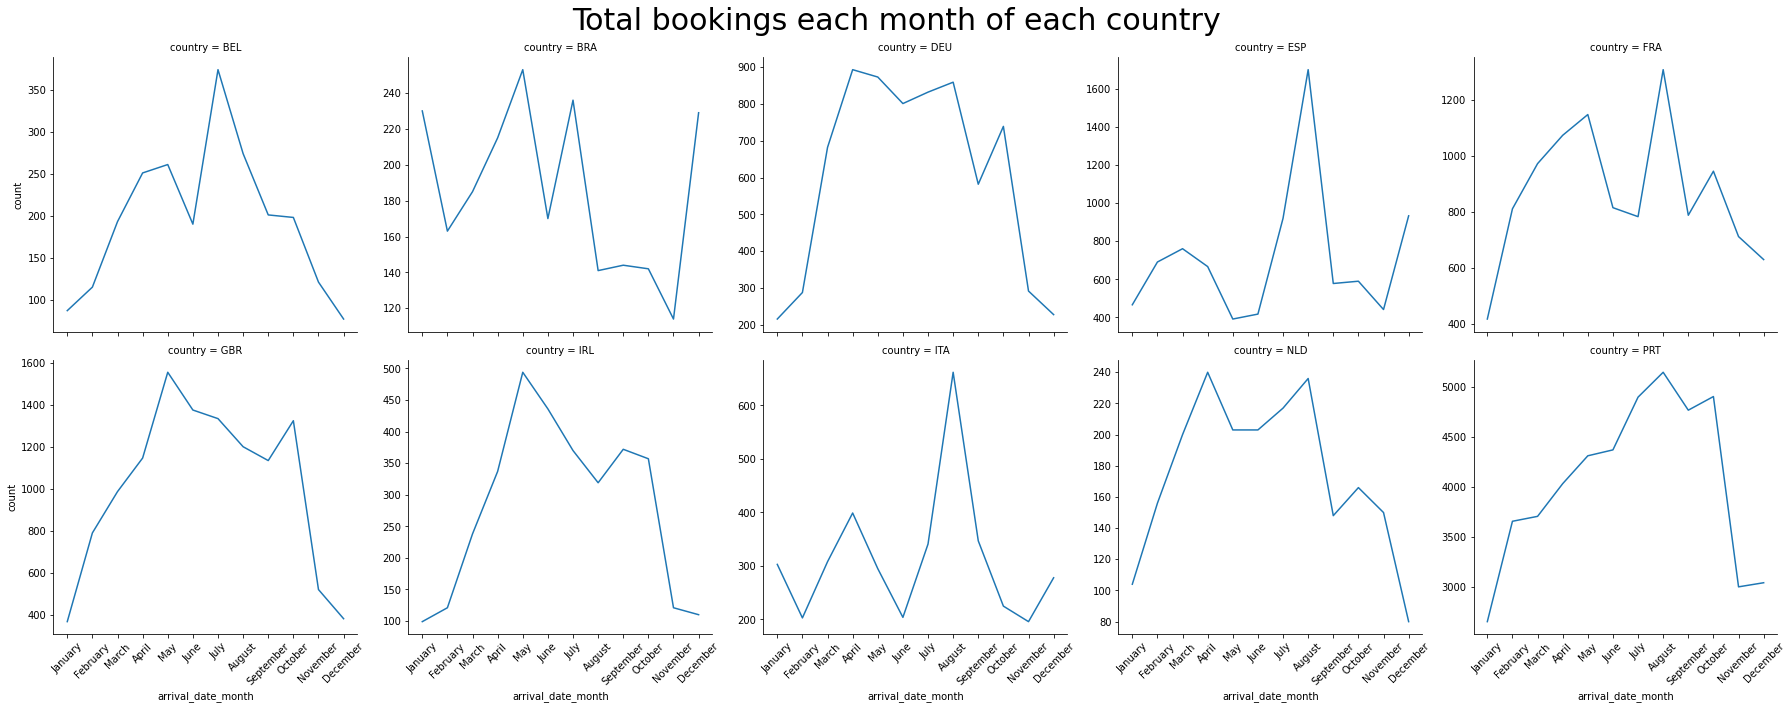

In [14]:
test1 = df.groupby(['country', 'arrival_date_month']).agg({'adr':'mean','hotel':'count'}).reset_index().rename(columns={'adr':'mean_adr','hotel':'count'})
plot = sns.relplot(data=test1,kind='line', x='arrival_date_month', y='count', col='country', facet_kws={'sharey': False, 'sharex': True}, col_wrap=5)
for axes in plot.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

plot.fig.suptitle('Total bookings each month of each country', fontsize=30)
plt.tight_layout()

## How many days guests usually stayed?

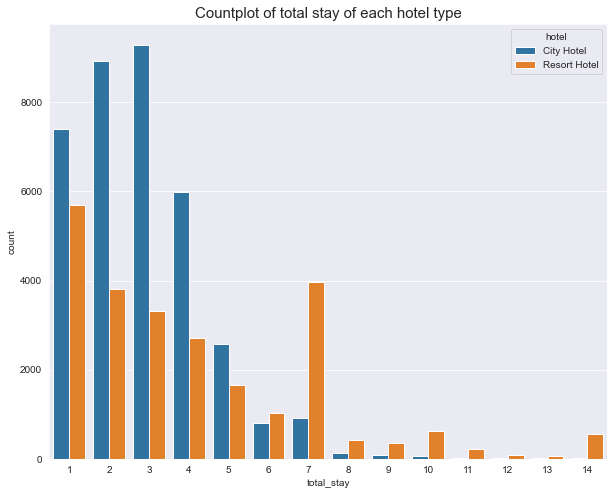

In [33]:
# Sum stays_in_weekend_nights and stays_in_week_nights
df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# filter total_stay == 0 or canceled booking
filter_1 = ((df['total_stay'] == 0) | (df['is_canceled'] == 1))
success_booking_df = df[~filter_1]
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 8))

sns.countplot(data=success_booking_df, x='total_stay', hue='hotel', hue_order=['City Hotel', 'Resort Hotel'])
plt.title('Countplot of total stay of each hotel type', fontsize=15)
plt.xlim(-0.5, 13.5)
plt.show()

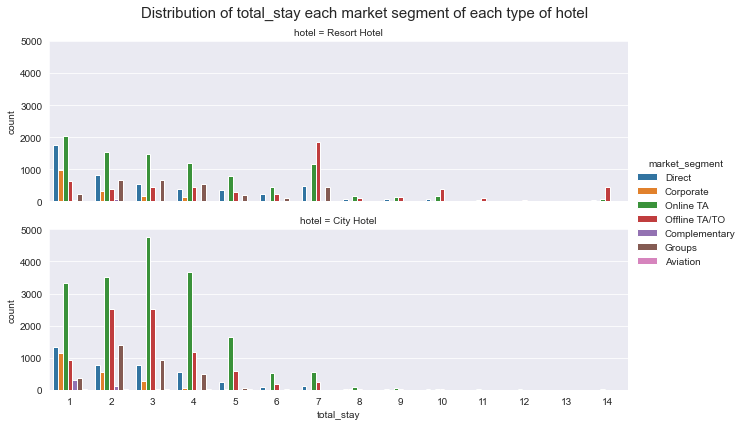

In [16]:
# Group by market_segment (city, resort)
g = sns.catplot(data=success_booking_df, x='total_stay', hue='market_segment', kind='count',
            height=3, aspect=3, row='hotel')

plt.xlim(-0.5,13.5)
g.fig.subplots_adjust(top = 0.9)
plt.suptitle('Distribution of total_stay each market segment of each type of hotel', fontsize=15)
plt.show()

People prefered to stay long-term on Resort more than city hotel, 7 days and 14 days are pretty popular in Resort Hotel through Offline TA/TO
<br>In city hotel, 3 days was the most popular choices, made a bookthrough Online TA.

## Factors influenced callcelation
We will simply see the correlation of between each variable and is_canceled

In [17]:
df.corr()['is_canceled']

is_canceled                       1.000000
lead_time                         0.314540
arrival_date_year                 0.002455
arrival_date_week_number          0.015177
arrival_date_day_of_month        -0.004751
stays_in_weekend_nights          -0.017411
stays_in_week_nights              0.010279
adults                            0.054783
children                         -0.008292
babies                           -0.033473
is_repeated_guest                -0.094666
previous_cancellations            0.115171
previous_bookings_not_canceled   -0.062405
booking_changes                  -0.156358
agent                            -0.038225
company                          -0.086118
days_in_waiting_list              0.065737
adr                               0.037752
required_car_parking_spaces      -0.205533
total_of_special_requests        -0.245852
total_stay                        0.000786
Name: is_canceled, dtype: float64

There are some columns disappear, so we will turn categorical data to numerical first.

In [18]:
# Copy 
df_1 = df.copy()

# Categorical data column
cols = ['hotel', 'is_canceled', 'arrival_date_month', 'market_segment', 'country', 'distribution_channel','deposit_type']
# Collect the data to use in explaining
all_mapping = dict()
for col in cols:
    test10 = list(df[col].unique())
    test11 = np.arange(0,len(test10))
    mapping = dict(zip(test10,test11))
    all_mapping[col] = mapping 
    df_1[col] = df_1[col].replace(mapping)

# Category data type doesn't work with cor function, manually turn them to numeric (int)
df_1['is_canceled'] = df_1['is_canceled'].astype(int)
df_1['arrival_date_month'] = df_1['arrival_date_month'].astype(int)

In [19]:
# Run the corr function again, now it has is_canceled column
df_1.corr()['is_canceled'].abs().sort_values(ascending=False)

is_canceled                       1.000000
deposit_type                      0.508495
lead_time                         0.314540
market_segment                    0.277933
total_of_special_requests         0.245852
country                           0.242388
required_car_parking_spaces       0.205533
distribution_channel              0.179365
booking_changes                   0.156358
hotel                             0.146637
previous_cancellations            0.115171
is_repeated_guest                 0.094666
company                           0.086118
days_in_waiting_list              0.065737
previous_bookings_not_canceled    0.062405
adults                            0.054783
agent                             0.038225
adr                               0.037752
babies                            0.033473
stays_in_weekend_nights           0.017411
arrival_date_week_number          0.015177
arrival_date_month                0.012463
stays_in_week_nights              0.010279
children   

So there are many factors let's look deeper one by one

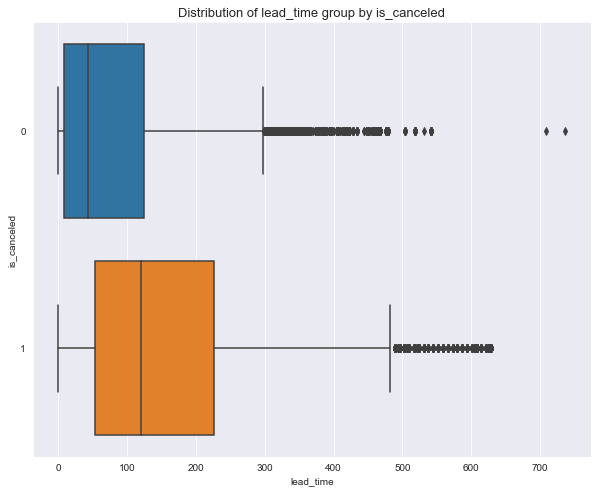

In [20]:
# lead_time
df['is_canceled'] = pd.Categorical(df['is_canceled'])
plt.figure(figsize=(10,8))
sns.boxplot(y='is_canceled', x='lead_time', data =df, orient='h')
plt.title('Distribution of lead_time group by is_canceled', fontsize=13)
plt.show()

We can see that the canceled booking had a longer duration of lead_time, in other words, longer the lead time, higher chance the booking will be canceled.

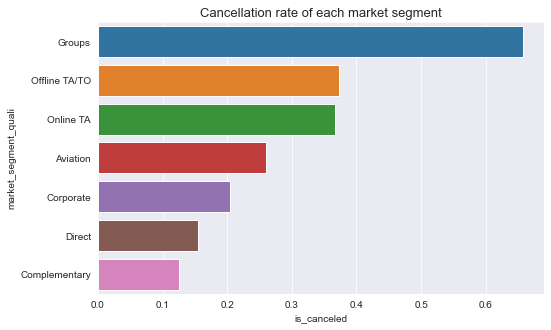

In [21]:
# Market segment
canceled_by_market_segment = df_1.groupby('market_segment')['is_canceled'].mean().reset_index()
canceled_by_market_segment['market_segment_quali'] = all_mapping['market_segment'].keys()
canceled_by_market_segment.sort_values('is_canceled', ascending=False, inplace=True)
plt.figure(figsize=(8,5))
sns.barplot(data=canceled_by_market_segment, y='market_segment_quali', x='is_canceled', orient='h')
plt.title('Cancellation rate of each market segment', fontsize=13)
plt.show()

We can see that some each market segment had a very high cancel rate. Groups had cancel more than half of the total booking. So the market segment definitely influenced the cancel rate, it's not a causation, but this can be used in predicting model.

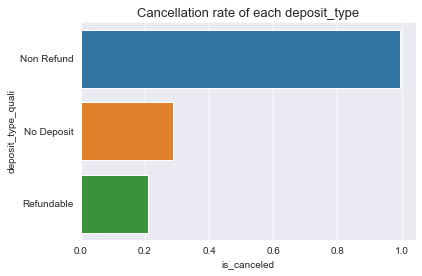

In [22]:
# Deposit_type
canceled_by_deposit_type = df_1.groupby('deposit_type')['is_canceled'].mean().reset_index()
canceled_by_deposit_type['deposit_type_quali'] = all_mapping['deposit_type'].keys()
canceled_by_deposit_type.sort_values('is_canceled',ascending=False, inplace=True)
sns.barplot(data=canceled_by_deposit_type, orient='h', x='is_canceled', y='deposit_type_quali')
plt.title('Cancellation rate of each deposit_type', fontsize=13)
plt.show()

Well, non-refund canceled about 99% of the total bookings, which really surprise me because it would make more sense the refundable and non-deposit to have a higher chance of booking cancellation, so I have to check the data again.

In [23]:
df.groupby('deposit_type')['is_canceled'].value_counts()

deposit_type   
No Deposit    0    61302
              1    24679
Non Refund    1    14429
              0       86
Refundable    0      121
              1       32
Name: is_canceled, dtype: int64

Look like there was no mistake of the data.

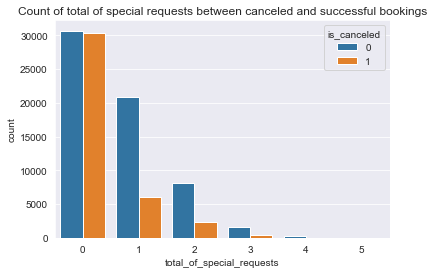

In [24]:
# total_of_special_requests
sns.countplot(data=df_1, x='total_of_special_requests', hue='is_canceled')
plt.title('Count of total of special requests between canceled and successful bookings', fontsize=12)
plt.show()

When the guests did not ask for a special request, there is an equal chance whether the booking will be canceled or not. If the guests made a request of special event. The chance of the booking cancellation was decreased a lot. Those days are important days of the guests.

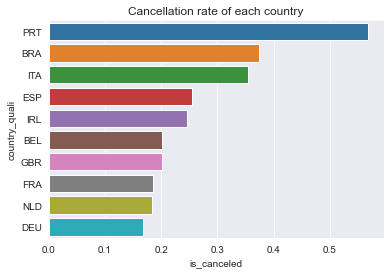

In [25]:
# country
canceled_by_country = df_1.groupby('country')['is_canceled'].mean().reset_index()
canceled_by_country['country_quali'] = all_mapping['country'].keys()
canceled_by_country.sort_values('is_canceled', ascending=False, inplace=True)
sns.barplot(data=canceled_by_country, x='is_canceled',y='country_quali', orient='h')
plt.title('Cancellation rate of each country', fontsize=12)
plt.show()

In [26]:
# required_car_parking_spaces
df_1.groupby('required_car_parking_spaces').is_canceled.value_counts()

required_car_parking_spaces  is_canceled
0                            0              55205
                             1              39140
1                            0               6274
2                            0                 27
3                            0                  3
Name: is_canceled, dtype: int64

There were no canceled bookings at all when there was a request of car parking space, this is probably the guests can get the parking space only when the guests were actually there. So this won't be included in my model prediction since it is not practical.

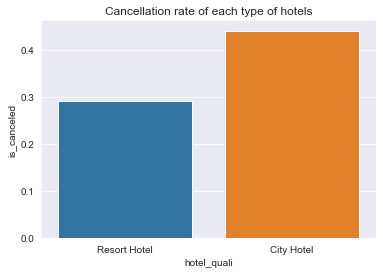

In [37]:
# Hotel
cancel_by_hotel = df_1.groupby('hotel').is_canceled.mean().reset_index()
cancel_by_hotel['hotel_quali'] = all_mapping['hotel']
sns.barplot(data = cancel_by_hotel, x='hotel_quali', y='is_canceled')
plt.title('Cancellation rate of each type of hotels')
plt.show()

City hotel had higher cancellation rate than resort hotel.

# Create a model to predict cancellation bookings
We will create a logistic regression model using statsmodels library, but first let's split the data for testing and traning (30:70)

In [28]:
from statsmodels.formula.api import logit

## Splitting data

In [38]:
# Split data 70 Train 30 Test
np.random.seed(51)
test_data = df_1.sample(n=int(len(df_1) * 0.3))
train_data = df_1[~df_1.isin(test_data)].dropna()
print(f"Total rows of original data: {len(df_1)}\nTotal rows of test data: {len(test_data)}\nTotal rows of train data: {len(train_data)}")

Total rows of original data: 100649
Total rows of test data: 30194
Total rows of train data: 70455


## Building a model

In [39]:
# These variables or factors are brought from the question above.
model = logit("is_canceled ~ lead_time + total_of_special_requests + C(deposit_type) + C(hotel) + C(market_segment)", data=train_data).fit()
train_data['predicted_probability'] = model.predict()
# Treshold = 0.5
train_data['predicted_outcome'] = train_data['predicted_probability'] > 0.5

Optimization terminated successfully.
         Current function value: 0.469514
         Iterations 9


### Evaluate the model
Evaluate the model by create confusion matrix. 
<br> We will look at 4 metrics to measure how good the model
- Accuracy
- Precision
- Recall
- F1-score

In [40]:
# Confusion matrix
conf_matrix = pd.crosstab(train_data['is_canceled'], train_data['predicted_outcome'])

# Evaluate model

# Accuracy
accuracy = (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,1])  / sum(sum(conf_matrix.values))
# Precision
precision = (conf_matrix.iloc[1,1] / (conf_matrix.iloc[1,1] + conf_matrix.iloc[0,1]))
# Recall
recall = conf_matrix.iloc[1,1] / (conf_matrix.iloc[1,1] + conf_matrix.iloc[1,0])
# F1-Score
f1_score = 2  * precision * recall / (precision+recall) 

print(conf_matrix)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall:{recall}\nF1-score:{f1_score}")

predicted_outcome  False   True
is_canceled                    
0.0                40820   2323
1.0                13305  14007
Accuracy: 0.7781846568731815
Precision: 0.8577464788732394
Recall:0.5128514938488576
F1-score:0.6419045873241372


With threshold = 0.5, accuracy is quite good, but the recall is a problem, the model tends to predict that bookings are not canceled, so the precision is high but low recall which resulting to bad F1-score, we are going to reduce threshold down a bit, allowing the model to predict more canceled booking to increase Recall and F1-score.

In [41]:
train_data['predicted_outcome'] = train_data['predicted_probability'] > 0.44
conf_matrix = pd.crosstab(train_data['is_canceled'], train_data['predicted_outcome'])
# Accuracy
accuracy = (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,1])  / sum(sum(conf_matrix.values))
# Precision
precision = (conf_matrix.iloc[1,1] / (conf_matrix.iloc[1,1] + conf_matrix.iloc[0,1]))
# Recall
recall = conf_matrix.iloc[1,1] / (conf_matrix.iloc[1,1] + conf_matrix.iloc[1,0])
# F1-Score
f1_score = 2  * precision * recall / (precision+recall) 

print(conf_matrix)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall:{recall}\nF1-score:{f1_score}")

predicted_outcome  False   True
is_canceled                    
0.0                38696   4447
1.0                10708  16604
Accuracy: 0.7848981619473423
Precision: 0.7887511282124364
Recall:0.6079379027533685
F1-score:0.6866406136922855


Now the model has a better overall accuracy with 0.44 threshold, let's test this with test_data, if the model is good, the result must be similar with this.
<br> **Train data: Accuracy: 78.45%, Precision: 78.87%, Recall: 60.79%, F1-score: 68.66%**

## Test the model with test_data
We are going to use the model we built predicting the test data, to see if the model works or not? We are expecting a similar result as the train data.

In [42]:
test_data['predicted_probability'] = model.predict(test_data)
test_data['predicted_outcome'] = test_data['predicted_probability'] > 0.44
conf_matrix = pd.crosstab(test_data['is_canceled'], test_data['predicted_outcome'])
# Accuracy
accuracy = (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,1])  / sum(sum(conf_matrix.values))
# Precision
precision = (conf_matrix.iloc[1,1] / (conf_matrix.iloc[1,1] + conf_matrix.iloc[0,1]))
# Recall
recall = conf_matrix.iloc[1,1] / (conf_matrix.iloc[1,1] + conf_matrix.iloc[1,0])
# F1-Score
f1_score = 2  * precision * recall / (precision+recall) 

print(conf_matrix)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall:{recall}\nF1-score:{f1_score}")

predicted_outcome  False  True
is_canceled                   
0                  16401  1965
1                   4586  7242
Accuracy: 0.7830363648406968
Precision: 0.7865754317367221
Recall:0.6122759553601623
F1-score:0.6885666745899691


**Test data: Accuracy:78.30%, Precision: 78.65%, Recall: 61.22%, F1-score: 68.86%**
<br>The result is very similar to the train model, so this model works well!